In [1]:
# get all imports out of the way
import tensorneat as tn
import jax.numpy as jnp
import pandas as pd

In [201]:
# get all the symbols we can pull live data for
import os

# Path to the directory
directory_path = "hist_data/stocks/single"

# List all files in the directory
files = os.listdir(directory_path)

live_syms = [file.split('_')[0] for file in files]

# drop nans split by symbol and join on date
file_path = "hist_data/stocks/sp500_stocks.csv"  # Update this path if needed
df = pd.read_csv(file_path)

df = df.dropna()

symbols = df['Symbol'].unique()
symbol_dfs = {symbol: df[df['Symbol'] == symbol] for symbol in symbols}

merged_df = symbol_dfs[symbols[0]].set_index('Date')

for symbol in symbols[1:]:
    symbol_data = symbol_dfs[symbol].set_index('Date')
    if (len(symbol_data) == 3768 and symbol in live_syms):
        merged_df = merged_df.join(symbol_data, how='inner', rsuffix=f"_{symbol}")

tensorneat_input = merged_df.to_numpy()

print(tensorneat_input.shape)

(3768, 1029)


In [202]:
print(merged_df.head())

           Symbol  Adj Close     Close      High       Low      Open  \
Date                                                                   
2010-01-04    AOS   5.937266  7.435000  7.480000  7.261667  7.295000   
2010-01-05    AOS   5.861404  7.340000  7.431667  7.308333  7.431667   
2010-01-06    AOS   5.864068  7.343333  7.405000  7.301667  7.335000   
2010-01-07    AOS   5.881369  7.365000  7.425000  7.311667  7.356667   
2010-01-08    AOS   5.967879  7.473333  7.485000  7.311667  7.331667   

               Volume Symbol_ABT  Adj Close_ABT  Close_ABT  ...    Low_WMB  \
Date                                                        ...              
2010-01-04  1104600.0        ABT      18.763718  26.129908  ...  17.445280   
2010-01-05  1207200.0        ABT      18.612118  25.918797  ...  17.534952   
2010-01-06   663000.0        ABT      18.715481  26.062737  ...  17.771360   
2010-01-07   564000.0        ABT      18.870522  26.278646  ...  18.072985   
2010-01-08   504600.0      

In [203]:
# create a target array

close_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = merged_df[open_columns].pct_change().values
print(target.shape)

print(features.shape)

(3766, 147)
(3768, 147)


In [204]:
import jax.numpy as jnp
train_test_split = 0.9

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")


Sample Count: 3766
Train Size: 3389
Shape of INPUTS: (3389, 147)
Shape of RETURNS: (3389, 147)


In [205]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblem(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)
      
      # Find the index of the maximum output for each day
      selected_indices = jnp.argmax(actions, axis=1)
      
      # Calculate the reward based on the selected index
      reward = jnp.take_along_axis(RETURNS, selected_indices[:, None], axis=1).squeeze()
      
      # Return the mean reward
      return jnp.mean(reward)

  def show(self, state, randkey, act_func, params, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      selected_indices = jnp.argmax(actions, axis=1)

      # Move data to host numpy
      from jax import device_get
      import numpy as np
      selected_indices_np = np.asarray(device_get(selected_indices)).ravel()
      returns_np = np.asarray(device_get(TEST_RETURNS))

      # Ensure indices are within bounds
      num_columns = returns_np.shape[1]
      selected_indices_np = np.clip(selected_indices_np, 0, num_columns - 1)

      # Calculate performance based on selected indices
      perf = 100.0
      perf_hist = []
      last_pick = live_syms[selected_indices_np[-1]]
      print("Last selected symbol:", last_pick)
      for i in range(len(selected_indices_np)-1):
          selected_return = returns_np[i, selected_indices_np[i]]
          perf += perf * float(selected_return)
          perf_hist.append(float(perf))

      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblem()



In [231]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblemTopK(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params, k=3):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)

      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)

      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)

      # Gather the rewards for the top-k indices
      rewards = jnp.take_along_axis(RETURNS, topk_indices, axis=1)

      # Calculate the weighted reward
      weighted_rewards = jnp.sum(rewards, axis=1)
      return jnp.mean(weighted_rewards)

  def show(self, state, randkey, act_func, params, k=3, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      
      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)
      
      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)
      
      # Move data to host numpy
      from jax import device_get
      import numpy as np
      topk_indices_np = np.asarray(device_get(topk_indices))
      softmax_weights_np = np.asarray(device_get(topk_values))
      returns_np = np.asarray(device_get(TEST_RETURNS))
      
      # Calculate performance based on top-k weighted rewards
      perf = 100.0
      perf_hist = []
      todays_syms = [live_syms[i] for i in topk_indices_np[-1]]
      print("Today's selected symbols:", todays_syms)
      for i in range(len(topk_indices_np)-2):
          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[i]]
          
          # Calculate the weighted reward
          weighted_reward = np.mean(rewards)
          
          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))
      
      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

  def show_averaged(self, state, randkey, act_func, params_list, k=3, *args, **kwargs):
      """
      Show the averaged performance of multiple networks.
      
      Args:
          state: The state of the problem.
          randkey: Random key for JAX operations.
          act_func: Activation function for the networks.
          params_list: List of network parameters (one for each network).
          k: Number of top-k actions to consider.
      """
      import numpy as np
      from jax import device_get
      import matplotlib.pyplot as plt

      # Initialize performance tracking
      perf = 100.0
      perf_hist = []

      # Iterate over the test inputs
      for i in range(TEST_INPUTS.shape[0]):
          # Collect actions from all networks
          actions_list = [
              jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS[i:i+1, :])
              for params in params_list
          ]

          # Average the actions across all networks
          avg_actions = jnp.mean(jnp.stack(actions_list, axis=0), axis=0)

          # Get the top-k values and indices
          topk_values, topk_indices = jax.lax.top_k(avg_actions, k)

          # Apply softmax to the top-k values to get weights
          softmax_weights = jax.nn.softmax(topk_values, axis=1)

          # Move data to host numpy
          topk_indices_np = np.asarray(device_get(topk_indices))
          softmax_weights_np = np.asarray(device_get(softmax_weights))
          returns_np = np.asarray(device_get(TEST_RETURNS))

          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[0]]
          weighted_reward = np.sum(softmax_weights_np[0] * rewards)

          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))

      # Plot the performance history
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblemTopK()



In [ ]:
from tensorneat.pipeline import Pipeline
from tensorneat.algorithm.neat import NEAT
from tensorneat.genome import DefaultGenome, BiasNode, DefaultConn, DefaultMutation
from tensorneat.problem.func_fit import CustomFuncFit
from tensorneat.common import ACT, AGG
from tensorneat import algorithm

# Construct the pipeline and run
pipeline = Pipeline(
    algorithm=NEAT(
        pop_size=144,
        species_size=7,
        survival_threshold=0.1,
        compatibility_threshold=0.8,
        genome=DefaultGenome(
            max_nodes=500,
            max_conns=1500,
            num_inputs=features.shape[1],
            num_outputs=target.shape[1],
            init_hidden_layers=(3,),
            node_gene=BiasNode(
                bias_init_std=0.1,
                bias_mutate_power=0.05,
                bias_mutate_rate=0.01,
                bias_replace_rate=0.0,
                activation_options=ACT.tanh,
                aggregation_options=AGG.sum,
            ),
            conn_gene=DefaultConn(
                weight_init_mean=0.0,
                weight_init_std=0.1,
                weight_mutate_power=0.05,
                weight_replace_rate=0.0,
                weight_mutate_rate=0.001,
            ),
            output_transform=ACT.tanh,
        ),
    ),
    problem=TradingProblemTopK(),
    generation_limit=610,
    fitness_target=.1,
    seed=42,
    is_save=True,
    save_dir="./model_archive/tensorneat_checkpoints"
)

# initialize state
state = pipeline.setup()
# run until terminate
state, best = pipeline.auto_run(state)
# show result
pipeline.show(state, best)
state.save("./model_archive/tensorneat_checkpoints/evolving_state.pkl")

save to ./model_archive/tensorneat_checkpoints
initializing
initializing finished
start compile
compile finished, cost time: 2.968975s
Generation: 1, Cost time: 5638.96ms
 	fitness: valid cnt: 144, max: 0.0077, min: -0.0028, mean: 0.0016, std: 0.0018

	node counts: max: 298, min: 296, mean: 297.04
 	conn counts: max: 884, min: 587, mean: 859.69
 	species: 1, [144]

Generation: 2, Cost time: 5208.31ms
 	fitness: valid cnt: 144, max: 0.0119, min: -0.0016, mean: 0.0043, std: 0.0025

	node counts: max: 299, min: 296, mean: 297.18
 	conn counts: max: 885, min: 587, mean: 847.79
 	species: 1, [144]

Generation: 3, Cost time: 5275.70ms
 	fitness: valid cnt: 144, max: 0.0146, min: 0.0017, mean: 0.0082, std: 0.0027

	node counts: max: 298, min: 295, mean: 296.98
 	conn counts: max: 884, min: 294, mean: 824.74
 	species: 1, [144]

Generation: 4, Cost time: 5278.06ms
 	fitness: valid cnt: 144, max: 0.0153, min: 0.0054, mean: 0.0116, std: 0.0018

	node counts: max: 299, min: 295, mean: 297.00
 	co

In [65]:
sym_columns = [col for col in merged_df.columns if 'Symbol' in col]
sym_list = merged_df[sym_columns].iloc[0].values
print(sym_list)

['AOS' 'ABT' 'AES' 'ALB' 'ALL' 'GOOG' 'MO' 'AMZN' 'AXP' 'AMP' 'APH' 'ADM'
 'AJG' 'T' 'AXON' 'BKR' 'BAX' 'BDX' 'BBY' 'BK' 'BWA' 'BSX' 'BRO' 'BLDR'
 'COF' 'KMX' 'CCL' 'CAT' 'CE' 'CVX' 'CSCO' 'C' 'CLX' 'CME' 'CMCSA' 'ED'
 'STZ' 'GLW' 'CSGP' 'DE' 'DXCM' 'DLR' 'DG' 'DPZ' 'DOV' 'DHI' 'DTE' 'EMN'
 'EIX' 'EA' 'EQT' 'EFX' 'EQIX' 'EQR' 'ESS' 'EL' 'EXPE' 'FFIV' 'FDS' 'FAST'
 'FRT' 'FDX' 'FSLR' 'FTNT' 'BEN' 'FCX' 'GIS' 'GPN' 'HIG' 'HSIC' 'HRL'
 'HST' 'IEX' 'INCY' 'PODD' 'ICE' 'IFF' 'IP' 'ISRG' 'IRM' 'JBHT' 'JCI' 'K'
 'KIM' 'LH' 'LRCX' 'LEN' 'LKQ' 'MCD' 'MRK' 'MTD' 'MSFT' 'MSI' 'NDAQ'
 'NTAP' 'NFLX' 'NVDA' 'OMC' 'ON' 'ORCL' 'PKG' 'PH' 'PAYX' 'PEP' 'PM' 'PNW'
 'PNC' 'PPG' 'PPL' 'PFG' 'PGR' 'PEG' 'PHM' 'PWR' 'RJF' 'RTX' 'O' 'RF'
 'RVTY' 'CRM' 'SHW' 'SO' 'SWK' 'SBUX' 'TTWO' 'TJX' 'TT' 'TDG' 'TSN' 'USB'
 'UDR' 'UAL' 'UPS' 'UHS' 'VLO' 'VRSK' 'VRTX' 'VTRS' 'V' 'WRB' 'DIS' 'WEC'
 'WELL' 'WST' 'WDC' 'WMB' 'WTW']


In [213]:
live_dfs = {}
for sym in live_syms:
    sym_df = pd.read_csv(f"hist_data/stocks/single/{sym}_history.csv")
    sym_df["Symbol"] = sym
    live_dfs[sym] = sym_df.set_index('Date')
live_merged_df = live_dfs[live_syms[0]]
for sym in live_syms[1:]:
    symbol_data = live_dfs[sym].reindex(live_merged_df.index, fill_value=1)
    live_merged_df = live_merged_df.join(symbol_data, on='Date', how='outer', rsuffix=f"_{sym}")

print(len(live_merged_df))

280


In [214]:
# create a target array

close_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = live_merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = live_merged_df[open_columns].pct_change().values
print(target.shape)

print(features.shape)

(278, 147)
(280, 147)


In [215]:
import jax.numpy as jnp
train_test_split = 0.8

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")

Sample Count: 278
Train Size: 222
Shape of INPUTS: (222, 147)
Shape of RETURNS: (222, 147)


initializing
initializing finished
(500, 4) (1500, 3)
Today's selected symbols: ['NVDA', 'CCL', 'OMC']
Initial performance: 100.53391220680984
Final performance: 91.92397499653043


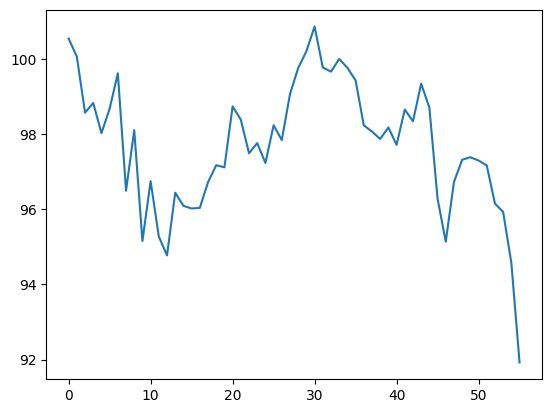

In [240]:
# for testing lasted genome from genomes checkpoints
import numpy as np
state = pipeline.setup()
best_path = "./model_archive/tensorneat_checkpoints/champs_topk/100_two.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

In [ ]:
import numpy as np
topk_champs = os.listdir("./model_archive/tensorneat_checkpoints/champs_topk/")
state = pipeline.setup()
best_path = "./model_archive/tensorneat_checkpoints/genomes/2.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

In [190]:
import yfinance as yf
import pandas as pd
import os

# Get the last date in merged_df
last_date = merged_df.index.max()
print(f"Last date in merged_df: {last_date}")


# Fetch historical data for all symbols in live_syms
for symbol in live_syms:
    print(f"Fetching data for {symbol}...")
    # Fetch data from the last date until now
    symbol_history = yf.download(symbol, start=last_date, progress=False)
    symbol_history.reset_index(inplace=True)
    symbol_history.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
    print(symbol_history.head())
    # Save the data to a CSV file
    output_path = f"hist_data/stocks/single/{symbol}_history.csv"
    symbol_history.to_csv(output_path, index=False)
    print(f"Saved {symbol} data to {output_path}")

Last date in merged_df: 2024-12-20
Fetching data for ABT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  111.540771  112.400052  109.871022  109.988200  12311900
1 2024-12-23  111.618881  111.814177  110.300665  111.316182   4028200
2 2024-12-24  112.058289  112.126640  110.915827  111.452882   1480000
3 2024-12-26  112.556267  113.083555  111.140406  111.511457   2960500
4 2024-12-27  112.282867  113.220266  111.814172  112.302401   2829500
Saved ABT data to hist_data/stocks/single/ABT_history.csv
Fetching data for ADM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  48.593872  49.055845  47.400438  47.544806  12132700
1 2024-12-23  48.516880  48.632372  47.766174  48.122278   2592200
2 2024-12-24  48.728619  48.795990  48.103028  48.516879   1434600
3 2024-12-26  48.709370  48.978853  48.391761  48.459132   1627600
4 2024-12-27  48.680496  49.267585  48.285890  48.391760   1537700
Saved ADM data to hist_data/stocks/single/ADM_history.csv
Fetching data for AES...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  12.104464  12.206886  11.508551  11.508551  25105700
1 2024-12-23  12.160330  12.188263  11.899618  12.002041  10108300
2 2024-12-24  12.123085  12.151018  11.992729  12.104462   3967400
3 2024-12-26  11.955484  12.095151  11.880995  12.067218   7272100
4 2024-12-27  11.871685  11.946174  11.713396  11.871685   9280700
Saved AES data to hist_data/stocks/single/AES_history.csv
Fetching data for AJG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  280.642914  283.953922  274.585928  277.093969  2774900
1 2024-12-23  282.040710  282.506632  278.382734  279.225363  1935200
2 2024-12-24  285.847321  285.996013  281.108809  282.744482  1045800
3 2024-12-26  285.857269  286.610683  283.696197  284.062981  1173300
4 2024-12-27  284.053101  286.491742  282.724734  285.341806  7622800
Saved AJG data to hist_data/stocks/single/AJG_history.csv
Fetching data for ALB...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  86.847923  88.699503  85.740889  86.083780  3685400
1 2024-12-23  87.386734  88.033321  86.318895  87.220192  2003000
2 2024-12-24  88.160675  88.307627  86.191540  87.621860   595100
3 2024-12-26  87.337761  88.591740  86.661785  87.690443  1194900
4 2024-12-27  86.495232  89.003189  85.525359  86.838115  1397000
Saved ALB data to hist_data/stocks/single/ALB_history.csv
Fetching data for ALL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  189.833847  191.167667  183.802244  184.802598  2351800
1 2024-12-23  189.902527  190.108476  188.009673  188.843316  1336100
2 2024-12-24  191.756134  192.050362  189.206180  190.137888   453200
3 2024-12-26  191.854202  192.148430  190.775387  191.697294   563300
4 2024-12-27  190.069244  192.020926  188.882531  190.422315  1094400
Saved ALL data to hist_data/stocks/single/ALL_history.csv
Fetching data for AMP...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  525.389771  528.786264  514.459776  514.657258  1498700
1 2024-12-23  527.473083  527.650800  521.776103  523.089238   427100
2 2024-12-24  531.965576  533.061523  526.199414  530.089583   145100
3 2024-12-26  535.529907  536.151944  529.951344  529.951344   213700
4 2024-12-27  529.171326  536.941781  527.443460  533.604527   308300


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved AMP data to hist_data/stocks/single/AMP_history.csv
Fetching data for AMZN...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  224.919998  226.210007  218.729996  219.839996  88279200
1 2024-12-23  225.059998  226.880005  223.899994  225.009995  28070000
2 2024-12-24  229.050003  229.139999  226.130005  226.940002  15007500
3 2024-12-26  227.050003  228.500000  226.669998  228.500000  16146700
4 2024-12-27  223.750000  226.029999  220.899994  225.600006  27367100
Saved AMZN data to hist_data/stocks/single/AMZN_history.csv
Fetching data for AOS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.002800  67.675560  66.369041  66.534791  2859700
1 2024-12-23  66.846786  66.963791  66.398282  66.515286   574400
2 2024-12-24  67.168541  67.168541  66.447035  66.768790   381800
3 2024-12-26  67.168541  67.509793  66.759038  66.924788   670600
4 2024-12-27  66.720032  67.344038  66.525032  66.885782   517900
Saved AOS data to hist_data/stocks/single/AOS_history.csv
Fetching data for APH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  70.040947  70.636363  68.423391  68.780642  12193100
1 2024-12-23  70.447807  70.656203  69.574531  70.249338   2970600
2 2024-12-24  71.112701  71.172241  70.269187  70.467664   1660900
3 2024-12-26  71.013451  71.251623  70.537121  70.705821   2882700
4 2024-12-27  70.199715  70.884447  69.733303  70.457731   4072300
Saved APH data to hist_data/stocks/single/APH_history.csv
Fetching data for AXON...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  631.690002  633.210022  605.099976  607.950012  7032800
1 2024-12-23  624.140015  642.530029  616.969971  634.640015   626700
2 2024-12-24  631.250000  631.780029  619.070007  619.669983   260500
3 2024-12-26  623.799988  630.000000  620.960022  630.000000   525800
4 2024-12-27  610.979980  622.460022  606.549988  620.950012   392100
Saved AXON data to hist_data/stocks/single/AXON_history.csv
Fetching data for AXP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  294.812195  298.829901  288.247657  288.593165  6232400
1 2024-12-23  294.960266  295.907951  291.396671  292.670102  1902400
2 2024-12-24  299.560364  299.718311  294.170536  295.443967   862900
3 2024-12-26  300.083557  300.972016  297.141871  297.605832  1228900
4 2024-12-27  297.181305  301.169397  294.871379  296.983893  1676000
Saved AXP data to hist_data/stocks/single/AXP_history.csv
Fetching data for BAX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  28.975822  29.457116  28.651686  28.818666  12194900
1 2024-12-23  28.661510  29.015114  28.239151  28.779377   4988400
2 2024-12-24  28.563290  28.651691  28.357022  28.494534   1577900
3 2024-12-26  28.779377  28.916891  28.288261  28.484708   2534200
4 2024-12-27  28.681156  28.838313  28.504354  28.563288   2773300
Saved BAX data to hist_data/stocks/single/BAX_history.csv
Fetching data for BBY...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  81.185165  81.555267  79.192303  79.543428  5213600
1 2024-12-23  80.966888  81.754543  80.217194  81.052300  2049200
2 2024-12-24  82.418839  82.418839  80.834045  81.004862  1025000
3 2024-12-26  84.810257  85.094946  82.001280  82.001280  2630100
4 2024-12-27  83.538628  84.506590  83.149550  84.259854  1773800
Saved BBY data to hist_data/stocks/single/BBY_history.csv
Fetching data for BDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  222.858582  224.454069  218.776888  219.217371  3104600
1 2024-12-23  221.644867  223.044578  220.529008  221.546979  1783700
2 2024-12-24  222.144058  222.320254  219.442510  221.918933   492300
3 2024-12-26  223.289276  224.346408  220.489840  221.537188  1154600
4 2024-12-27  223.651459  225.217568  221.918936  221.948300  1420900
Saved BDX data to hist_data/stocks/single/BDX_history.csv
Fetching data for BEN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  19.038290  19.437825  18.527258  18.564423  9415800
1 2024-12-23  19.010414  19.159080  18.833877  18.973249  3446200
2 2024-12-24  19.400660  19.437826  18.973251  19.084750  1350900
3 2024-12-26  19.474991  19.577198  19.224122  19.233413  2262400
4 2024-12-27  19.196247  19.530742  19.159082  19.363494  2362500
Saved BEN data to hist_data/stocks/single/BEN_history.csv
Fetching data for BKR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  39.476105  39.613174  38.497035  38.555780  17974900
1 2024-12-23  39.309662  39.417356  38.849498  39.172589   4094300
2 2024-12-24  39.936272  40.043970  39.055107  39.348827   2122000
3 2024-12-26  40.024384  40.043965  39.427150  39.936267   2289600
4 2024-12-27  39.946056  40.259358  39.671918  39.857940   3282500
Saved BKR data to hist_data/stocks/single/BKR_history.csv
Fetching data for BK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  75.603348  75.992949  74.113093  74.902053  13075300
1 2024-12-23  75.554634  75.632557  74.824120  74.941005   2670000
2 2024-12-24  76.022171  76.265676  75.320876  75.564381   1236500
3 2024-12-26  76.314369  76.450731  75.554636  75.729959   1970200
4 2024-12-27  75.554634  76.421510  75.077367  75.885804   2072300
Saved BK data to hist_data/stocks/single/BK_history.csv
Fetching data for BLDR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  150.500000  150.919998  145.850006  146.000000  4308000
1 2024-12-23  149.029999  150.389999  147.009995  149.139999  1722800
2 2024-12-24  148.820007  149.979996  147.690002  149.000000   588800
3 2024-12-26  148.179993  148.800003  146.029999  147.750000   959800
4 2024-12-27  145.080002  148.490005  144.380005  147.520004  1160600
Saved BLDR data to hist_data/stocks/single/BLDR_history.csv
Fetching data for BRO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  102.034676  102.956586  101.023551  101.410158  2726000
1 2024-12-23  101.905800  102.044581  100.745971  101.489447   773000
2 2024-12-24  102.946655  103.035876  101.301099  101.638138   338300
3 2024-12-26  102.837624  102.976405  102.064410  102.064410   588000
4 2024-12-27  101.995018  102.986320  101.489452  102.302319   676500
Saved BRO data to hist_data/stocks/single/BRO_history.csv
Fetching data for BSX...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  88.949997  89.669998  87.250000  88.000000  15909900
1 2024-12-23  89.860001  89.989998  88.360001  89.269997   3833800
2 2024-12-24  91.070000  91.089996  89.660004  89.860001   1880000
3 2024-12-26  91.449997  91.550003  90.589996  90.680000   2601600
4 2024-12-27  90.660004  91.500000  90.230003  90.900002   3177600
Saved BSX data to hist_data/stocks/single/BSX_history.csv
Fetching data for BWA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  31.406275  31.563899  30.795489  30.795489  7655000
1 2024-12-23  31.524496  31.613159  31.140292  31.248656  1907500
2 2024-12-24  31.701820  31.751077  31.337318  31.514643   718100
3 2024-12-26  31.780626  31.928399  31.455532  31.632857  1210000
4 2024-12-27  31.711668  32.145132  31.406275  31.485086  1191700
Saved BWA data to hist_data/stocks/single/BWA_history.csv
Fetching data for CAT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  359.752899  365.109272  351.104030  352.342398  5142000
1 2024-12-23  359.114044  360.057547  355.290845  358.602957  1804900
2 2024-12-24  361.256653  361.256653  356.430983  358.190247   886000
3 2024-12-26  360.814331  361.177971  357.620153  358.779878  1097900
4 2024-12-27  358.593140  361.089521  355.536571  357.148417  1245800
Saved CAT data to hist_data/stocks/single/CAT_history.csv
Fetching data for CCL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  26.799999  27.139999  25.440001  25.780001  61015000
1 2024-12-23  25.730000  26.540001  25.260000  26.520000  35169600
2 2024-12-24  25.790001  26.049999  25.420000  26.000000  10234900
3 2024-12-26  25.660000  25.830000  25.370001  25.480000  12363700
4 2024-12-27  25.080000  25.540001  24.889999  25.410000  14967400
Saved CCL data to hist_data/stocks/single/CCL_history.csv
Fetching data for CE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.082375  68.431513  66.566111  66.615984  7876500
1 2024-12-23  69.030037  69.458981  67.982620  68.321782  2011600
2 2024-12-24  68.232018  69.239539  67.972654  69.000123  1487200
3 2024-12-26  68.980164  69.099864  67.892837  68.172148  1222100
4 2024-12-27  68.591118  69.967726  68.112293  68.670916  2000800
Saved CE data to hist_data/stocks/single/CE_history.csv
Fetching data for CLX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  156.754532  157.288357  155.305568  156.764059  4020600
1 2024-12-23  155.467621  156.354163  153.360918  156.335093   766100
2 2024-12-24  155.791718  155.896577  154.562015  155.381822   399400
3 2024-12-26  156.306503  156.706872  155.343713  155.381837   601100
4 2024-12-27  155.381836  156.725940  154.638292  155.772677   596100
Saved CLX data to hist_data/stocks/single/CLX_history.csv
Fetching data for CMCSA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  34.116108  34.196442  33.303819  33.553752  64062787
1 2024-12-23  33.901878  34.107181  33.625164  33.946509  17799054
2 2024-12-24  34.276779  34.294633  33.660866  33.785835   7995138
3 2024-12-26  34.142883  34.330336  34.000065  34.142883  11549742
4 2024-12-27  33.857246  34.142884  33.643016  33.776908  16425611
Saved CMCSA data to hist_data/stocks/single/CMCSA_history.csv
Fetching data for CME...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  228.395279  230.099649  225.589776  226.930287  3172400
1 2024-12-23  227.897354  228.443143  225.790831  227.887784  1620100
2 2024-12-24  229.295319  229.381491  227.906930  227.954808   478400
3 2024-12-26  229.046356  229.448509  228.117569  228.337792  1174700
4 2024-12-27  229.134689  230.410389  227.378160  227.378160  1384000
Saved CME data to hist_data/stocks/single/CME_history.csv
Fetching data for COF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  176.400223  178.582398  172.075391  172.875188  5164300
1 2024-12-23  177.703613  178.078833  174.938871  175.165970  2095300
2 2024-12-24  179.826538  179.945037  177.387642  177.565383   931300
3 2024-12-26  180.063522  180.438742  177.743110  178.483665  1255600
4 2024-12-27  177.950470  180.547355  177.219783  178.809509  1209100
Saved COF data to hist_data/stocks/single/COF_history.csv
Fetching data for CRM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  341.421082  344.202939  328.992242  330.581840  14932300
1 2024-12-23  340.675934  341.619784  334.496276  340.030156   5330300
2 2024-12-24  342.196014  342.712661  338.619358  340.775297   1811000
3 2024-12-26  339.503632  342.643140  338.818104  342.643140   3483300
4 2024-12-27  336.254822  340.050022  333.095424  338.142492   3220400
Saved CRM data to hist_data/stocks/single/CRM_history.csv
Fetching data for CSCO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  56.745178  56.997291  55.533089  55.823990  69544600
1 2024-12-23  57.191227  57.230015  56.357309  56.367008  18671200
2 2024-12-24  58.034840  58.034840  57.016685  57.016685   9922300
3 2024-12-26  58.160900  58.238476  57.598493  57.811818   8524500
4 2024-12-27  57.802120  58.199685  57.346373  57.763332  13021400
Saved CSCO data to hist_data/stocks/single/CSCO_history.csv
Fetching data for CSGP...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  71.440002  71.860001  69.610001  69.889999  7036000
1 2024-12-23  72.739998  72.860001  70.110001  70.120003  2637900
2 2024-12-24  72.949997  73.000000  71.930000  72.330002  1159700
3 2024-12-26  73.099998  73.519997  71.800003  72.379997  1293000
4 2024-12-27  72.220001  72.800003  71.690002  72.279999  1702400
Saved CSGP data to hist_data/stocks/single/CSGP_history.csv
Fetching data for CVX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  136.521301  136.521301  134.323196  134.581238  32209200
1 2024-12-23  136.635986  136.999156  135.269332  136.167690   8156500
2 2024-12-24  137.467438  137.658574  135.957435  136.760231   3556100
3 2024-12-26  137.601242  137.916624  136.569088  137.304978   4492600
4 2024-12-27  137.620346  139.254594  137.037370  137.897492   5296500
Saved CVX data to hist_data/stocks/single/CVX_history.csv
Fetching data for C...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  66.973167  68.008885  65.850330  66.102002  27720100
1 2024-12-23  67.534569  67.641045  66.663411  67.137709   8248000
2 2024-12-24  68.725174  68.928445  67.699139  67.854008   6544900
3 2024-12-26  69.063942  69.180100  68.250859  68.279897   6341700
4 2024-12-27  68.725174  69.238192  68.279913  68.589660   7743100
Saved C data to hist_data/stocks/single/C_history.csv
Fetching data for DE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  425.025421  428.966220  418.391923  418.657282  2446400
1 2024-12-23  424.917297  425.162982  419.630149  425.162982  1093900
2 2024-12-24  425.369385  426.106440  421.310662  423.177863   383200
3 2024-12-26  426.352173  427.934401  423.010861  424.337567   444900
4 2024-12-27  422.637360  427.659179  419.718619  424.868170   735300
Saved DE data to hist_data/stocks/single/DE_history.csv
Fetching data for DG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.170692  74.568725  71.636850  71.636850  5865400
1 2024-12-23  72.442627  73.568775  71.238804  73.355193  5089400
2 2024-12-24  72.462044  72.821250  71.957220  72.326129  1542300
3 2024-12-26  73.423157  73.607615  71.996057  72.568837  3600700
4 2024-12-27  73.675575  74.287190  72.996004  73.190165  2659700
Saved DG data to hist_data/stocks/single/DG_history.csv
Fetching data for DHI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  137.969650  139.116024  135.686794  136.309382  7848000
1 2024-12-23  138.444016  138.542847  136.200698  137.623766  2410100
2 2024-12-24  139.392761  139.600285  137.465675  137.653430  1162200
3 2024-12-26  139.807816  140.677481  138.246378  138.355086  1677400
4 2024-12-27  138.631805  140.420537  138.048741  138.928284  1624300
Saved DHI data to hist_data/stocks/single/DHI_history.csv
Fetching data for DIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  110.804588  111.734309  109.222091  109.400122  17955300
1 2024-12-23  110.181488  110.626563  109.103407  110.389190   6037200
2 2024-12-24  111.328789  111.506820  109.973779  110.033120   2475000
3 2024-12-26  111.318909  112.080483  110.636454  110.893612   4781400
4 2024-12-27  110.329849  110.893614  109.647394  110.596893   4523800
Saved DIS data to hist_data/stocks/single/DIS_history.csv
Fetching data for DLR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  173.230240  176.043515  170.523661  171.522860  4801700
1 2024-12-23  173.133224  173.763782  171.270640  173.346647  2167100
2 2024-12-24  175.005508  175.005508  172.628774  173.036213   683700
3 2024-12-26  174.132416  174.607769  173.162319  173.831688   693500
4 2024-12-27  172.813095  174.248835  172.027319  172.890705   822900
Saved DLR data to hist_data/stocks/single/DLR_history.csv
Fetching data

C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  187.169693  188.504703  185.419330  186.437899  2381100
1 2024-12-23  186.714783  187.337796  184.885321  186.269779   611000
2 2024-12-24  188.217926  188.415704  186.358783  186.358783   215500
3 2024-12-26  188.791489  189.365054  187.169688  187.377349   299000
4 2024-12-27  186.240097  189.365034  185.567635  187.209218   457400
Saved DOV data to hist_data/stocks/single/DOV_history.csv
Fetching data for DPZ...
        Date       Close        High         Low        Open  Volume
0 2024-12-20  419.487579  425.728017  417.351672  421.899118  932700
1 2024-12-23  419.841949  420.875449  413.847586  418.906856  332800
2 2024-12-24  424.231873  425.363808  418.148926  420.816362  214900
3 2024-12-26  425.826447  427.529291  421.603805  421.751474  300900
4 2024-12-27  422.873566  425.698493  421.200279  421.200279  291000
Saved DPZ data to hist_data/stocks/single/DPZ_history.csv
Fetching data for DTE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  116.255760  116.555635  112.889389  113.121558  3035900
1 2024-12-23  116.323471  116.478250  115.036898  116.130005   899000
2 2024-12-24  116.816826  116.865189  116.149354  116.149354   309900
3 2024-12-26  117.136040  117.387552  116.120330  116.323472   533400
4 2024-12-27  117.387550  118.093717  116.178367  116.458898  1074800
Saved DTE data to hist_data/stocks/single/DTE_history.csv
Fetching data for DXCM...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  80.040001  81.510002  75.470001  75.470001  11578500
1 2024-12-23  79.540001  80.250000  77.800003  78.900002   2389400
2 2024-12-24  80.239998  80.830002  78.589996  79.559998   1153100
3 2024-12-26  80.570000  80.669998  79.250000  79.540001   1350500
4 2024-12-27  80.239998  80.500000  79.629997  80.029999   1797800
Saved DXCM data to hist_data/stocks/single/DXCM_history.csv
Fetching data for EA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  147.095718  148.946856  146.000954  146.379148  4055500
1 2024-12-23  146.598083  146.916551  145.801893  146.916551  1708600
2 2024-12-24  148.469116  148.936878  146.309459  146.707562   778600
3 2024-12-26  148.359665  148.777662  147.244992  147.633133   883400
4 2024-12-27  147.414169  148.140702  146.329367  147.752561  1023500
Saved EA data to hist_data/stocks/single/EA_history.csv
Fetching data for ED...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.026688  87.510008  85.818386  85.818386  4876400
1 2024-12-23  86.678696  86.891358  85.828054  86.891358  1979000
2 2024-12-24  86.591698  86.736695  86.127707  86.417702   653900
3 2024-12-26  86.601364  87.123351  86.031049  86.253380  1879800
4 2024-12-27  86.572372  86.959030  85.866729  86.031056  1319600
Saved ED data to hist_data/stocks/single/ED_history.csv
Fetching data for EFX...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  256.398376  260.872931  252.578652  252.896128  1788100
1 2024-12-23  256.457916  257.261546  253.670009  255.366588   480400
2 2024-12-24  259.216064  259.523625  252.201652  255.366592   208700
3 2024-12-26  256.765503  259.940359  256.279365  256.299196   432500
4 2024-12-27  253.967682  257.013540  252.677898  254.354615   406600
Saved EFX data to hist_data/stocks/single/EFX_history.csv
Fetching data for EIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.027359  74.157695  72.416858  72.491334  5974300
1 2024-12-23  74.213554  74.222866  73.040584  74.027365  1959100
2 2024-12-24  74.716248  74.753486  73.934265  74.381113   997100
3 2024-12-26  74.483521  74.688326  74.055295  74.334569  1000200
4 2024-12-27  74.278717  74.781419  73.915656  73.962198   985500
Saved EIX data to hist_data/stocks/single/EIX_history.csv
Fetching data for EL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  73.071251  74.240629  72.688011  72.717490  7621000
1 2024-12-23  73.454498  74.063756  72.363735  72.648710  2995200
2 2024-12-24  73.778778  73.985138  72.186852  73.474146  1162700
3 2024-12-26  73.700165  74.574739  73.218659  73.582242  1740500
4 2024-12-27  73.326759  73.916359  72.412877  72.835425  1853400
Saved EL data to hist_data/stocks/single/EL_history.csv
Fetching data for EMN...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.705063  88.096941  84.952327  85.382446  2504100
1 2024-12-23  87.179359  88.049149  86.290457  87.294059  1175500
2 2024-12-24  87.523453  87.666826  86.806596  87.102894   309200
3 2024-12-26  87.466110  87.848435  86.902179  86.988206   695100
4 2024-12-27  87.685936  88.603512  87.188918  87.236704  1104100


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved EMN data to hist_data/stocks/single/EMN_history.csv
Fetching data for EQIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  906.432068  915.474687  898.679862  901.935222  1434600
1 2024-12-23  918.524780  921.144689  902.316481  911.427537   488700
2 2024-12-24  928.711182  928.711182  916.677169  918.524810   168400
3 2024-12-26  927.127563  930.881439  921.858390  927.987839   234800
4 2024-12-27  921.526001  928.867640  918.446658  918.827929   289700
Saved EQIX data to hist_data/stocks/single/EQIX_history.csv
Fetching data for EQR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.799767  68.531457  66.459929  67.011064  5177000
1 2024-12-23  67.885300  68.046839  67.001574  67.229630  1300900
2 2024-12-24  68.626488  68.740512  67.533708  67.676246   568700
3 2024-12-26  68.769020  68.940064  68.227382  68.464943   747200
4 2024-12-27  68.018326  69.044589  67.856786  68.151359   946100
Saved EQR data to hist_data/stocks/single/EQR_history.csv
Fetching data for EQT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  42.479664  43.121945  41.916427  42.084411  12908800
1 2024-12-23  43.339336  43.477674  42.341324  42.489545   4813900
2 2024-12-24  44.050789  44.228649  43.112066  43.566604   2013600
3 2024-12-26  43.655540  44.110079  43.191119  43.635777   2712300
4 2024-12-27  43.793877  44.446042  43.438150  43.645656   4508300
Saved EQT data to hist_data/stocks/single/EQT_history.csv
Fetching data for ESS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  271.092102  274.426289  267.796109  267.901213  1417600
1 2024-12-23  271.636658  272.219441  268.550873  269.706847   386400
2 2024-12-24  273.986877  274.005974  269.668645  271.894643   121600
3 2024-12-26  274.865753  276.289255  272.955039  273.404058   231600
4 2024-12-27  271.732147  275.668213  270.776790  273.136523   298700
Saved ESS data to hist_data/stocks/single/ESS_history.csv
Fetching data for EXPE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  183.270660  184.034499  175.959679  175.959679  4134800
1 2024-12-23  187.327911  187.952872  181.911639  184.748739  1461500
2 2024-12-24  188.161163  188.716692  186.742621  187.744528   366200
3 2024-12-26  188.597641  188.766278  186.990618  188.200850   879500
4 2024-12-27  184.619766  188.577823  183.221053  186.306151  1395000
Saved EXPE data to hist_data/stocks/single/EXPE_history.csv
Fetching data for FAST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  36.430229  36.600645  35.748561  35.836205  15509000
1 2024-12-23  36.264679  36.478915  36.016356  36.362058   4135000
2 2024-12-24  36.571430  36.586037  36.152692  36.342584   2134600
3 2024-12-26  36.235462  36.444831  36.181902  36.332845   2531800
4 2024-12-27  35.553795  36.001750  35.217833  35.982274   5252600
Saved FAST data to hist_data/stocks/single/FAST_history.csv
Fetching data for FCX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  38.181255  38.603745  37.296974  37.316625  22372300
1 2024-12-23  38.564449  38.652877  37.886502  38.240211   8562500
2 2024-12-24  38.534969  38.701998  38.132131  38.682347   3962500
3 2024-12-26  38.505489  38.633220  38.240205  38.358112   6127100
4 2024-12-27  38.181255  38.495666  37.886496  38.220558   7892500
Saved FCX data to hist_data/stocks/single/FCX_history.csv
Fetching data for FDS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  477.962677  480.097855  464.924273  479.020386  922800
1 2024-12-23  483.715820  484.200179  474.502931  474.502931  264300
2 2024-12-24  485.702759  486.345282  482.094715  484.259547  110700
3 2024-12-26  485.959717  487.294207  481.827766  482.163855  163900
4 2024-12-27  480.967773  487.333758  477.300422  484.526403  155200
Saved FDS data to hist_data/stocks/single/FDS_history.csv
Fetching data for FDX...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  269.356720  288.415741  264.638345  287.204412  8126800
1 2024-12-23  262.792084  268.751064  258.962678  268.643621  3500700
2 2024-12-24  265.556641  266.230694  261.414654  262.782288  1013100
3 2024-12-26  272.219025  273.821102  264.052243  264.101105  1777300
4 2024-12-27  273.879730  275.091089  270.148049  270.919767  1553200
Saved FDX data to hist_data/stocks/single/FDX_history.csv
Fetching data for FFIV...

C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  252.250000  254.009995  248.020004  249.259995  1233800
1 2024-12-23  254.410004  254.809998  250.880005  251.750000   269700
2 2024-12-24  256.200012  257.040009  253.899994  253.990005   172600
3 2024-12-26  257.119995  257.899994  254.699997  255.630005   204200
4 2024-12-27  255.630005  256.869995  253.669998  254.110001   212200
Saved FFIV data to hist_data/stocks/single/FFIV_history.csv
Fetching data for FRT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  105.896599  107.003629  103.881235  103.881235  1825000
1 2024-12-23  106.095299  106.303460  105.045037  105.480287   480200
2 2024-12-24  106.663017  106.823866  105.745220  105.745220   210100
3 2024-12-26  106.719780  107.041478  105.508669  106.085840   269500
4 2024-12-27  105.432968  106.918472  105.073422  106.180452   383300
Saved FRT data to hist_data/stocks/single/FRT_history.csv
Fetching data for FSLR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  182.389999  183.009995  173.360001  174.460007  3462900
1 2024-12-23  186.360001  186.830002  180.520004  183.399994  1718400
2 2024-12-24  186.210007  189.139999  184.500000  186.839996   671900
3 2024-12-26  183.710007  186.500000  183.240005  184.509995   732000
4 2024-12-27  182.630005  184.740005  180.520004  184.039993  1034100
Saved FSLR data to hist_data/stocks/single/FSLR_history.csv
Fetching data for FTNT...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  97.190002  97.830002  93.360001  93.720001  13324400
1 2024-12-23  96.419998  97.070000  95.339996  96.930000   3107900
2 2024-12-24  97.809998  97.830002  96.320000  96.650002   1764900
3 2024-12-26  97.290001  97.599998  96.730003  97.160004   1661500
4 2024-12-27  96.080002  96.510002  94.800003  96.510002   2774700
Saved FTNT data to hist_data/stocks/single/FTNT_history.csv
Fetching data for GIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  59.982208  60.821449  59.718178  60.642283  10672900
1 2024-12-23  59.925625  60.246234  59.397565  59.557868   3380200
2 2024-12-24  60.104797  60.189665  59.576734  59.595594   1220400
3 2024-12-26  60.123653  60.689437  59.850195  59.878483   2212100
4 2024-12-27  60.302814  60.519697  59.878478  59.982205   1984400
Saved GIS data to hist_data/stocks/single/GIS_history.csv
Fetching data for GLW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  46.427639  46.427639  45.672000  45.829015  11445800
1 2024-12-23  46.614090  46.682784  46.152855  46.398192   2852200
2 2024-12-24  47.006630  47.006630  46.162669  46.466885   1592800
3 2024-12-26  47.094952  47.153830  46.574834  46.722038   1960200
4 2024-12-27  46.888866  47.173459  46.565023  46.722039   2255000
Saved GLW data to hist_data/stocks/single/GLW_history.csv
Fetching data for GOOG...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  192.211716  193.382147  185.647260  186.284777  45319700
1 2024-12-23  195.229950  195.728011  190.886858  193.277544  15235900
2 2024-12-24  196.803833  196.903436  194.441022  195.409253   6809800
3 2024-12-26  196.335648  197.391534  195.110407  195.977043   7907900
4 2024-12-27  193.287506  196.036813  191.227533  195.708090  14693000
Saved GOOG data to hist_data/stocks/single/GOOG_history.csv
Fetching data for GPN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  110.709251  111.519584  108.120144  108.396842  3300500
1 2024-12-23  110.491844  110.748781  108.298015  109.622221  1053900
2 2024-12-24  111.648056  111.875340  110.145971  110.145971   439200
3 2024-12-26  112.418861  112.735089  110.412795  110.867371   821200
4 2024-12-27  111.025482  112.833910  110.570906  111.489942  1038600
Saved GPN data to hist_data/stocks/single/GPN_history.csv
Fetching data for HIG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  107.652168  107.957018  104.347963  104.878997  5819000
1 2024-12-23  107.898026  108.075037  106.826122  107.022805  1095600
2 2024-12-24  108.733910  108.753574  107.445665  107.888190   397800
3 2024-12-26  109.137100  109.235438  108.173371  108.517557   574200
4 2024-12-27  108.281548  109.559963  107.957026  108.242211   856000
Saved HIG data to hist_data/stocks/single/HIG_history.csv
Fetching data for HRL...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  30.016277  30.215248  29.864680  29.978377  4859800
1 2024-12-23  29.893105  30.044702  29.694134  29.826781  1845800
2 2024-12-24  29.949955  30.092077  29.703609  29.836256   844000
3 2024-12-26  30.016277  30.101551  29.732031  29.798357  1253000
4 2024-12-27  30.177351  30.319473  29.826781  29.826781  1718600
Saved HRL data to hist_data/stocks/single/HRL_history.csv
Fetching data for HSIC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  69.820000  70.330002  68.430000  68.949997  2761500
1 2024-12-23  70.059998  70.750000  69.459999  69.589996  1111900
2 2024-12-24  70.010002  70.239998  69.440002  69.949997   421000
3 2024-12-26  70.970001  72.540001  69.760002  70.000000   851500
4 2024-12-27  70.419998  71.129997  69.839996  70.269997   501200
Saved HSIC data to hist_data/stocks/single/HSIC_history.csv
Fetching data for HST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  16.888891  17.037365  16.127962  16.174361  19799300
1 2024-12-23  16.768257  16.898171  16.619784  16.870333   4286000
2 2024-12-24  16.907452  16.953851  16.712581  16.786817   1710000
3 2024-12-26  16.963131  17.018808  16.786818  16.879614   3034500
4 2024-12-27  16.684738  16.926008  16.545544  16.833212   7022200
Saved HST data to hist_data/stocks/single/HST_history.csv
Fetching data for ICE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  148.626541  149.645004  146.342415  146.688501  6446800
1 2024-12-23  148.478210  148.735293  147.103779  147.716830  2853800
2 2024-12-24  148.774857  148.883625  147.924488  148.478214  1084600
3 2024-12-26  149.328568  149.674638  147.528944  147.528944  1168100
4 2024-12-27  148.636429  149.654892  147.855268  148.201354  1212400
Saved ICE data to hist_data/stocks/single/ICE_history.csv
Fetching data for IEX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  208.450241  209.598590  203.140341  205.623526  1243600
1 2024-12-23  206.860229  208.597483  206.516715  207.174316   424000
2 2024-12-24  208.352097  208.764323  206.281138  206.281138   156300
3 2024-12-26  209.039139  210.393609  207.380407  207.959502   401800
4 2024-12-27  207.203766  209.480830  206.310600  207.360809   166100
Saved IEX data to hist_data/stocks/single/IEX_history.csv
Fetching data for IFF...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  83.779770  84.835080  82.812406  83.300975  4203000
1 2024-12-23  82.851494  83.652746  81.932982  83.515948  1334600
2 2024-12-24  83.164169  83.574565  82.792860  83.056684   378400
3 2024-12-26  82.988297  83.486639  82.675613  82.802638   592600
4 2024-12-27  82.656059  83.369373  82.323836  82.372696   740700


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved IFF data to hist_data/stocks/single/IFF_history.csv
Fetching data for INCY...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.839996  69.110001  66.889999  66.889999  6805500
1 2024-12-23  69.839996  70.190002  68.150002  68.580002  1611100
2 2024-12-24  69.910004  70.099998  68.919998  69.879997   395900
3 2024-12-26  69.559998  70.110001  69.250000  69.519997   764500
4 2024-12-27  69.230003  69.900002  68.190002  68.709999   966400
Saved INCY data to hist_data/stocks/single/INCY_history.csv
Fetching data for IP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  52.316490  52.354924  51.413320  51.567050  6737000
1 2024-12-23  52.354923  52.354923  51.259589  51.932161  2549000
2 2024-12-24  52.950630  52.989064  52.460611  52.700816   879400
3 2024-12-26  53.046711  53.181225  52.739250  52.941021  1743000
4 2024-12-27  52.354923  52.998669  52.143542  52.844938  1681200
Saved IP data to hist_data/stocks/single/IP_history.csv
Fetching data for IRM...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  101.441193  103.255750   98.941361   99.037878  5696100
1 2024-12-23  101.557022  101.672840   98.680760  100.852432  2095900
2 2024-12-24  101.904495  101.904495  100.485668  101.238514   767700
3 2024-12-26  102.049271  102.290567  100.543573  101.489460   879900
4 2024-12-27  101.074425  102.029958  100.408443  100.977907   954200
Saved IRM data to hist_data/stocks/single/IRM_history.csv
Fetching data for ISRG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  524.429993  530.969971  516.179993  521.450012  3933900
1 2024-12-23  527.219971  527.940002  520.030029  524.880005  1069800
2 2024-12-24  537.020020  537.359985  527.260010  528.010010   629200
3 2024-12-26  538.830017  540.130005  533.989990  534.859985   765700
4 2024-12-27  534.880005  537.340027  529.309998  536.010010  1013200
Saved ISRG data to hist_data/stocks/single/ISRG_history.csv
Fetching data for JBHT...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  168.273636  169.410429  163.597999  166.573402  2140300
1 2024-12-23  168.580078  168.916182  166.603063  167.690427   513300
2 2024-12-24  169.598236  169.706957  167.729942  168.125355   180900
3 2024-12-26  170.033188  170.487908  168.323074  168.748140   268000
4 2024-12-27  170.033188  171.110673  168.105601  169.390664   298300


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved JBHT data to hist_data/stocks/single/JBHT_history.csv
Fetching data for JCI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  79.621826  80.006901  77.281747  77.607583  6394200
1 2024-12-23  79.661514  80.068207  78.897735  79.195308  4021000
2 2024-12-24  80.336014  80.336014  79.334175  79.403609  1241100
3 2024-12-26  80.197151  80.623679  79.849979  80.107882  1348600
4 2024-12-27  79.175468  80.147558  78.858053  79.135791  1651800
Saved JCI data to hist_data/stocks/single/JCI_history.csv
Fetching data for KIM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  22.329638  22.510792  21.938726  21.967330  9672400
1 2024-12-23  22.339174  22.415450  22.129416  22.234295  3739800
2 2024-12-24  22.520327  22.558463  22.215223  22.234293  1557400
3 2024-12-26  22.510794  22.625206  22.377310  22.396380  1580800
4 2024-12-27  22.281967  22.606136  22.205692  22.405914  2023500
Saved KIM data to hist_data/stocks/single/KIM_history.csv
Fetching data for KMX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  84.269997  85.400002  82.120003  85.400002  4192700
1 2024-12-23  83.699997  84.199997  82.529999  84.110001  1864100
2 2024-12-24  84.910004  85.199997  83.629997  84.000000   901600
3 2024-12-26  85.169998  85.540001  83.790001  84.230003  1160300
4 2024-12-27  83.769997  85.309998  83.269997  84.099998  1319900
Saved KMX data to hist_data/stocks/single/KMX_history.csv
Fetching data for K...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  78.269234  78.740794  78.103946  78.113664  5307417
1 2024-12-23  78.463684  78.483134  78.220612  78.220612  1228725
2 2024-12-24  78.580368  78.638703  78.337296  78.337296   577930
3 2024-12-26  78.862335  78.881778  78.492868  78.512311   909371
4 2024-12-27  78.920662  79.037339  78.697040  78.784542   921988
Saved K data to hist_data/stocks/single/K_history.csv
Fetching data for LEN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  130.842148  132.557260  129.411299  130.662108  9358257
1 2024-12-23  130.766342  131.979258  130.017760  130.387309  3821997
2 2024-12-24  130.766342  132.007682  130.283085  130.283085  2198947
3 2024-12-26  131.372757  132.187685  129.648160  129.818731  2752945
4 2024-12-27  129.998795  132.320373  129.449191  130.766331  2101122
Saved LEN data to hist_data/stocks/single/LEN_history.csv
Fetching data for LH...
        Date       Close        High         Low        Open  Volume
0 2024-12-20  226.101746  227.249022  224.074235  225.350090  996900
1 2024-12-23  225.340195  226.081966  222.778615  225.448988  510600
2 2024-12-24  226.972076  227.585269  223.233551  224.657739  144100
3 2024-12-26  228.524841  229.147934  226.497331  226.517115  430800
4 2024-12-27  227.901764  229.860051  226.536915  227.288571  339800
Saved LH data to hist_data/stocks/single/LH_history.csv
Fetching data for LKQ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  35.649483  36.065136  34.711846  34.992171  6251000
1 2024-12-23  35.639812  35.833140  35.088831  35.552815  1566500
2 2024-12-24  35.475487  35.697812  35.427156  35.697812  1320300
3 2024-12-26  35.765476  35.833140  35.282159  35.514153  1294500
4 2024-12-27  35.659145  35.929802  35.417487  35.485151  1193800
Saved LKQ data to hist_data/stocks/single/LKQ_history.csv
Fetching data for LRCX...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  71.138512  72.803266  69.662035  69.899855  29404500
1 2024-12-23  73.130272  73.318543  71.346604  71.693426  10406700
2 2024-12-24  73.160011  73.496922  72.565458  73.397831   5611700
3 2024-12-26  73.318550  73.883377  72.337536  72.585268   6297400
4 2024-12-27  72.733902  73.090636  71.980797  72.634811   5444100
Saved LRCX data to hist_data/stocks/single/LRCX_history.csv
Fetching data for MCD...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  286.008942  289.351003  282.705977  282.920964  7678000
1 2024-12-23  284.650665  286.419408  283.126225  285.598557  2492200
2 2024-12-24  287.289062  287.562679  284.162018  284.640840  1461000
3 2024-12-26  288.080597  288.706024  285.930760  286.321636  1433900
4 2024-12-27  286.927490  289.722318  286.067543  286.653873  1617200
Saved MCD data to hist_data/stocks/single/MCD_history.csv
Fetching data for MO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  49.280891  49.317505  48.374722  48.438794  27063800
1 2024-12-23  49.042904  49.290038  48.466251  49.280886   7199600
2 2024-12-24  48.942223  49.097826  48.868995  49.079519   5406800
3 2024-12-26  49.082188  49.250150  48.484990  48.783589   5230800
4 2024-12-27  48.876900  49.315464  48.615623  48.839574   6425500
Saved MO data to hist_data/stocks/single/MO_history.csv
Fetching data for MRK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  94.497452  96.068391  94.352885  95.249190  29289700
1 2024-12-23  95.769623  95.981646  94.642009  95.499762   8460500
2 2024-12-24  95.846710  96.029828  95.220267  95.625048   3713500
3 2024-12-26  96.251503  96.318966  95.335919  95.499758   4760300
4 2024-12-27  96.087654  96.714105  95.644322  95.894903   6173600
Saved MRK data to hist_data/stocks/single/MRK_history.csv
Fetching data for MSFT...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  433.402893  440.490593  425.491254  429.938429  64263700
1 2024-12-23  432.062775  434.445194  429.660482  433.541854  19152500
2 2024-12-24  436.112854  436.380896  431.010509  431.467132   7164500
3 2024-12-26  434.901825  437.711119  433.432682  435.864723   8194200
4 2024-12-27  427.377319  432.032978  423.227936  431.417523  18117700
Saved MSFT data to hist_data/stocks/single/MSFT_history.csv
Fetching data for MSI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  464.861084  467.462665  455.028509  456.047376  2508300
1 2024-12-23  464.692902  465.167725  458.589601  463.871885   652500
2 2024-12-24  467.343964  467.353835  463.228920  464.880854   235400
3 2024-12-26  466.216278  466.977945  463.683948  465.375458   292300
4 2024-12-27  462.279236  465.533687  460.538278  463.357482   364800
Saved MSI data to hist_data/stocks/single/MSI_history.csv
Fetching data for MTD...
        Date        Close         High          Low         Open  Volume
0 2024-12-20  1230.739990  1240.660034  1197.119995  1206.069946  275200
1 2024-12-23  1234.390015  1236.329956  1219.150024  1219.439941   87700
2 2024-12-24  1246.300049  1248.199951  1229.770020  1233.770020   33600
3 2024-12-26  1245.280029  1247.020020  1234.430054  1234.430054   45200
4 2024-12-27  1234.229980  1245.760010  1228.869995  1231.359985   70700
Saved MTD data to hist_data/stocks/single/MTD_history.csv
F

C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  76.753395  77.622679  76.150826  76.437294  7181700
1 2024-12-23  76.990471  77.257178  76.269361  76.615096  1775300
2 2024-12-24  77.958527  77.998040  76.743516  77.049737   846400
3 2024-12-26  78.156097  78.432685  77.425107  77.543648  1842400
4 2024-12-27  77.464615  78.215358  77.109000  77.672056  1347000
Saved NDAQ data to hist_data/stocks/single/NDAQ_history.csv
Fetching data for NFLX...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  90.904999  91.991997  89.049004  89.320999  45305000
1 2024-12-23  91.144997  91.500000  89.910004  91.342003  23394000
2 2024-12-24  93.211998  93.584999  91.169998  91.500000  23203000
3 2024-12-26  92.414001  93.049004  91.529999  92.839996  23403000
4 2024-12-27  90.754997  91.813004  89.449997  91.600998  32262000
Saved NFLX data to hist_data/stocks/single/NFLX_history.csv
Fetching data for NTAP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  115.532402  116.868660  112.264919  113.084232  3813600
1 2024-12-23  115.171516  115.776240  114.157132  115.347083  1457000
2 2024-12-24  115.912796  115.932308  114.654577  115.093490   441300
3 2024-12-26  115.434868  116.312701  114.547286  115.581175   733800
4 2024-12-27  114.079102  114.849644  112.781860  114.186393   995000
Saved NTAP data to hist_data/stocks/single/NTAP_history.csv
Fetching data for NVDA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open     Volume
0 2024-12-20  134.663162  135.243005  128.184939  129.774500  306528600
1 2024-12-23  139.631790  139.751752  135.083032  136.242718  176053500
2 2024-12-24  140.181656  141.861189  138.612078  139.961715  105157000
3 2024-12-26  139.891739  140.811501  137.692343  139.661806  116205600
4 2024-12-27  136.972519  138.981979  134.673160  138.512106  170582600
Saved NVDA data to hist_data/stocks/single/NVDA_history.csv
Fetching data for OMC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  85.643127  86.558733  83.773356  84.457652  6003400
1 2024-12-23  83.561317  85.392536  83.426386  85.238332  1809200
2 2024-12-24  83.262543  83.628783  82.857749  83.628783   823500
3 2024-12-26  84.264900  84.467297  82.597526  82.771010  1218300
4 2024-12-27  83.358917  84.380548  83.098695  83.570954  1164200
Saved OMC data to hist_data/stocks/single/OMC_history.csv
Fetching data for ON...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  65.500000  66.860001  63.939999  64.220001  12758500
1 2024-12-23  66.629997  66.989998  65.449997  65.500000   5257400
2 2024-12-24  67.900002  67.919998  66.419998  66.629997   3044800
3 2024-12-26  67.019997  67.949997  66.989998  67.050003   3659500
4 2024-12-27  66.010002  67.050003  65.480003  66.699997   4751900
Saved ON data to hist_data/stocks/single/ON_history.csv
Fetching data for ORCL...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  167.546234  169.126291  163.566445  165.640272  13810500
1 2024-12-23  167.032715  167.506730  165.087258  167.477105   6518200
2 2024-12-24  169.274460  169.629975  166.924107  167.585758   2451500
3 2024-12-26  169.541061  170.400232  168.375770  168.375770   4100100
4 2024-12-27  166.854965  169.017668  165.116883  168.257272   4344300


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved ORCL data to hist_data/stocks/single/ORCL_history.csv
Fetching data for O...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  49.432655  50.153685  48.692897  48.692897  14467200
1 2024-12-23  49.629295  49.694843  49.104909  49.348376   5474900
2 2024-12-24  49.854038  49.854038  49.320286  49.516933   2585000
3 2024-12-26  49.694847  49.994495  49.526294  49.732304   7385900
4 2024-12-27  49.310928  50.078778  49.133013  49.563757   5373900
Saved O data to hist_data/stocks/single/O_history.csv
Fetching data for PAYX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  133.904831  134.451819  131.064375  131.064375  4925600
1 2024-12-23  133.712906  133.952810  132.407827  133.549773  1514700
2 2024-12-24  135.680130  135.977609  133.482615  133.722519   885800
3 2024-12-26  136.879623  137.100331  135.113934  135.373034  2364200
4 2024-12-27  135.564972  137.205907  134.931622  136.361455  2032100
Saved PAYX data to hist_data/stocks/single/PAYX_history.csv
Fetching data for PEG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  82.402222  82.518475  79.563772  79.796278  5833000
1 2024-12-23  82.566917  82.605661  81.181599  82.392541  1953600
2 2024-12-24  83.109413  83.157846  82.285974  82.431281   600800
3 2024-12-26  82.731606  83.051296  82.150355  82.818790   943300
4 2024-12-27  82.276291  82.479728  81.578787  82.072853  1356000
Saved PEG data to hist_data/stocks/single/PEG_history.csv
Fetching data for PEP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  146.918900  147.592013  144.726512  145.063069  19205200
1 2024-12-23  145.476547  146.553520  143.957273  146.553520   6822200
2 2024-12-24  146.938141  146.957376  144.630369  144.716907   3399800
3 2024-12-26  146.582367  147.293922  146.390055  146.668905   5528500
4 2024-12-27  147.015060  147.572775  145.447690  145.476536   4287000
Saved PEP data to hist_data/stocks/single/PEP_history.csv
Fetching data for PFG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.411415  74.661694  71.735293  71.995208  3446700
1 2024-12-23  74.507668  74.603929  73.660547  73.930090   900100
2 2024-12-24  74.892731  75.027499  74.064867  74.276647   271200
3 2024-12-26  75.412552  75.470315  74.555810  74.806097   372400
4 2024-12-27  74.806091  75.720596  74.469172  74.844597   726800
Saved PFG data to hist_data/stocks/single/PFG_history.csv
Fetching data for PGR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  221.123093  224.246846  218.294199  219.280170  5587400
1 2024-12-23  222.081390  222.551345  219.740885  220.865069  1847300
2 2024-12-24  224.136276  224.145486  221.473253  222.320996   680200
3 2024-12-26  224.090195  224.873428  222.855440  224.366636   952300
4 2024-12-27  222.090607  224.357394  221.187564  222.661908  1410400
Saved PGR data to hist_data/stocks/single/PGR_history.csv
Fetching data for PHM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  109.643707  110.298478  107.709171  108.304413  4865700
1 2024-12-23  109.256798  109.703234  108.135760  109.078225  1477300
2 2024-12-24  109.871880  109.951247  108.740919  108.988937   700900
3 2024-12-26  109.772682  110.229034  108.512747  108.949261  1259000
4 2024-12-27  108.651634  110.229031  108.066316  108.859976   990600
Saved PHM data to hist_data/stocks/single/PHM_history.csv
Fetching data for PH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  640.950684  645.605313  626.224272  628.759551  1338500
1 2024-12-23  639.415588  641.386363  633.433872  636.365312   599400
2 2024-12-24  646.268738  646.437079  634.741120  637.979564   227000
3 2024-12-26  645.129822  645.565576  640.237520  643.466051   256900
4 2024-12-27  637.593323  644.476225  631.393760  639.762178   392500
Saved PH data to hist_data/stocks/single/PH_history.csv
Fetching data for PKG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  222.360275  223.199077  220.214508  220.575383  1955900
1 2024-12-23  221.482483  222.399314  219.746361  221.189875   630700
2 2024-12-24  223.179596  223.462441  221.141103  222.331031   513100
3 2024-12-26  223.794052  224.184201  222.370049  222.769932   661400
4 2024-12-27  221.492218  223.930593  220.760706  222.360279   894100
Saved PKG data to hist_data/stocks/single/PKG_history.csv
Fetching data for PM...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  118.663132  119.188524  116.743045  117.020073  10267400
1 2024-12-23  118.242813  118.433871  116.599755  118.185499   3697100
2 2024-12-24  117.411736  118.548497  117.077387  117.956237   2806600
3 2024-12-26  117.556618  118.145802  117.064020  117.344124   2425600
4 2024-12-27  117.305481  117.817401  116.774254  117.498660   3923500
Saved PM data to hist_data/stocks/single/PM_history.csv
Fetching data fo

C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  184.464020  185.095618  180.865847  181.143360  3961400
1 2024-12-23  184.808517  184.980778  182.167307  183.019003  1493600
2 2024-12-24  185.727203  185.889885  183.679305  185.220015   724300
3 2024-12-26  186.387512  186.511907  183.908969  185.153023   746600
4 2024-12-27  184.961639  187.114804  183.937698  185.287003   886400
Saved PNC data to hist_data/stocks/single/PNC_history.csv
Fetching data for PNW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  80.823509  81.489432  79.995865  80.252723  1900600
1 2024-12-23  80.861565  81.185007  80.033920  80.775950  1087800
2 2024-12-24  81.441856  81.670169  80.785448  81.089868   359400
3 2024-12-26  81.280136  81.613094  80.709343  81.042308   798100
4 2024-12-27  80.813995  81.622617  80.623736  80.642759   642600
Saved PNW data to hist_data/stocks/single/PNW_history.csv
Fetching data for PODD...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  266.570007  270.700012  256.559998  256.559998  1466000
1 2024-12-23  263.329987  266.440002  258.970001  264.820007   493700
2 2024-12-24  263.230011  264.170013  261.540009  263.910004   140100
3 2024-12-26  265.679993  266.420013  261.260010  261.260010   244000
4 2024-12-27  265.119995  266.589996  262.269989  262.609985   312900


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved PODD data to hist_data/stocks/single/PODD_history.csv
Fetching data for PPG...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  117.115181  118.644761  115.527148  116.189642  3884400
1 2024-12-23  117.056725  117.319770  115.770708  116.861869  1470800
2 2024-12-24  117.865356  118.108920  116.481909  116.988526   539000
3 2024-12-26  118.108925  118.245320  116.959304  116.978786  1021600
4 2024-12-27  117.280800  118.790898  116.852133  117.319771   993100
Saved PPG data to hist_data/stocks/single/PPG_history.csv
Fetching data for PPL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  31.411627  31.440684  30.849840  30.869213  10037100
1 2024-12-23  31.392252  31.450369  31.101673  31.266333   3014800
2 2024-12-24  31.576290  31.595663  31.305084  31.392258    964200
3 2024-12-26  31.595659  31.653776  31.411627  31.556918   1636400
4 2024-12-27  31.498800  31.721577  31.314768  31.382570   2271200
Saved PPL data to hist_data/stocks/single/PPL_history.csv
Fetching data for PWR...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  327.930573  330.436918  318.853846  319.113446  2080900
1 2024-12-23  326.902069  327.950524  323.067679  326.862119   595300
2 2024-12-24  330.327026  330.327026  326.802181  329.328486  1196900
3 2024-12-26  330.137299  330.886204  326.233003  329.687974   294500
4 2024-12-27  322.668274  328.909150  319.922289  327.670939   582000
Saved PWR data to hist_data/stocks/single/PWR_history.csv
Fetching data for RF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  22.780523  22.905111  22.052160  22.071328  29520600
1 2024-12-23  22.847609  22.924278  22.569680  22.665517   5356700
2 2024-12-24  23.020117  23.020117  22.684686  22.809274   2592000
3 2024-12-26  22.991364  23.010531  22.713436  22.885942   5432900
4 2024-12-27  22.751770  23.144703  22.636766  22.790106   6100100
Saved RF data to hist_data/stocks/single/RF_history.csv
Fetching data for RJF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  152.533295  152.710366  147.958763  147.958763  3880300
1 2024-12-23  153.280945  153.290792  150.910059  151.529838   766000
2 2024-12-24  154.727097  154.727097  152.818583  153.605601   242900
3 2024-12-26  156.133881  156.242096  153.635101  153.635101   710400
4 2024-12-27  154.372940  156.458524  153.566258  154.825480   565000
Saved RJF data to hist_data/stocks/single/RJF_history.csv
Fetching data for RTX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  114.348114  114.642619  112.502518  112.836299  13389200
1 2024-12-23  114.495361  114.750605  113.670739  114.063420   3588700
2 2024-12-24  114.691711  114.819329  113.759094  113.827813   1663000
3 2024-12-26  114.897858  115.467244  114.259753  114.632795   2147000
4 2024-12-27  114.573906  115.378898  113.719826  114.141957   3847500
Saved RTX data to hist_data/stocks/single/RTX_history.csv
Fetching data for RVTY...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  112.175980  113.272233  109.774206  109.774206  2049600
1 2024-12-23  111.886971  112.056396  109.973523  110.940215   659700
2 2024-12-24  111.956734  112.724111  110.900352  111.857076   214100
3 2024-12-26  112.116188  112.335439  110.561513  111.069767   266200
4 2024-12-27  111.607933  112.305549  110.601384  110.930253   345800
Saved RVTY data to hist_data/stocks/single/RVTY_history.csv
Fetching data for SBUX...
        Date      Close       High        Low       Open    Volume
0 2024-12-20  85.694862  86.854088  84.818137  85.587707  26477500
1 2024-12-23  85.178581  85.607197  84.068065  85.237027  11203700
2 2024-12-24  87.584709  87.594445  84.915567  85.139622   5422000
3 2024-12-26  89.484261  89.669349  87.058661  87.058661   7538700
4 2024-12-27  89.864174  90.789601  88.529603  88.549090   8200400
Saved SBUX data to hist_data/stocks/single/SBUX_history.csv
Fetching data for SHW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  342.419678  346.265424  336.304142  336.740260  3294800
1 2024-12-23  341.795227  342.756664  337.751265  341.309563  1083300
2 2024-12-24  343.460419  343.460419  339.010072  340.764434   445900
3 2024-12-26  342.459381  343.579409  339.822864  339.822864   750500
4 2024-12-27  340.258972  343.381154  338.365833  341.051897   881700
Saved SHW data to hist_data/stocks/single/SHW_history.csv
Fetching data for SO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  80.176956  80.409183  78.764233  79.102898  7725000
1 2024-12-23  80.351128  80.409182  79.306097  80.167278  2556400
2 2024-12-24  80.467247  80.476918  80.031814  80.370479  1146300
3 2024-12-26  80.157600  80.486595  79.828613  80.031813  2177500
4 2024-12-27  80.447891  80.622063  79.596389  79.654443  2603000
Saved SO data to hist_data/stocks/single/SO_history.csv
Fetching data for STZ...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  220.559372  221.954645  219.464467  221.460477  4614700
1 2024-12-23  219.328827  221.189186  216.732065  219.793913  1394800
2 2024-12-24  218.398636  218.989689  216.383258  218.737770   579600
3 2024-12-26  217.303711  219.164070  217.003343  217.332778   951900
4 2024-12-27  215.792191  217.623483  214.435668  216.063492  1190100
Saved STZ data to hist_data/stocks/single/STZ_history.csv
Fetching data for SWK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  78.343658  79.012443  76.060228  76.146211  4890900
1 2024-12-23  77.722633  78.123904  76.891431  77.760851  1562100
2 2024-12-24  77.502907  77.588890  76.929655  77.588890   454300
3 2024-12-26  77.302269  77.598444  76.671695  76.843669   927800
4 2024-12-27  76.986977  77.837291  76.451942  76.652584   870200
Saved SWK data to hist_data/stocks/single/SWK_history.csv
Fetching data for TDG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date        Close         High          Low         Open  Volume
0 2024-12-20  1194.046143  1210.167595  1166.771548  1166.771548  608200
1 2024-12-23  1207.575806  1213.133702  1182.518727  1187.926886  271900
2 2024-12-24  1217.914917  1217.914917  1201.091718  1204.338440   91500
3 2024-12-26  1217.512451  1218.691395  1208.305561  1215.304301  108500
4 2024-12-27  1207.847168  1214.396808  1201.072978  1206.228490  154000
Saved TDG data to hist_data/stocks/single/TDG_history.csv
Fetching data for TJX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  120.506248  122.027394  119.518492  119.617266  11714000
1 2024-12-23  120.279053  120.634646  118.827058  120.051873   5436900
2 2024-12-24  121.978004  121.978004  120.269191  120.496370   1476100
3 2024-12-26  123.479393  123.696701  121.889105  121.938488   2892800
4 2024-12-27  122.422501  123.232460  122.175562  122.402741   3471500
Saved TJX data to hist_data/stocks/single/TJX_history.csv
Fetching data for TSN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  56.026947  56.615993  55.775876  56.335954  5593700
1 2024-12-23  55.843475  56.007634  55.003358  55.215802  1823000
2 2024-12-24  55.756565  55.978664  55.457213  55.669657   682800
3 2024-12-26  56.084888  56.239392  55.428247  55.524810  1821400
4 2024-12-27  55.978664  56.355267  55.611717  55.785534  1543400
Saved TSN data to hist_data/stocks/single/TSN_history.csv
Fetching data for TTWO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  181.970001  184.199997  179.000000  180.000000  3579400
1 2024-12-23  183.220001  183.369995  181.089996  181.089996  1198400
2 2024-12-24  185.389999  185.820007  183.630005  184.000000   461100
3 2024-12-26  187.160004  187.559998  184.710007  184.750000   733500
4 2024-12-27  186.429993  188.360001  184.699997  187.429993  1010700
Saved TTWO data to hist_data/stocks/single/TTWO_history.csv
Fetching data for TT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  374.398315  377.664667  369.285353  372.303502  2647400
1 2024-12-23  374.775604  375.530149  369.335028  374.299075   800300
2 2024-12-24  377.198059  377.476044  373.504807  374.805385   287800
3 2024-12-26  375.321655  377.098762  374.060768  376.314465   349300
4 2024-12-27  370.844086  374.616749  368.054294  372.660914   654600
Saved TT data to hist_data/stocks/single/TT_history.csv
Fetching data for T...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  21.522251  21.522251  21.304664  21.370886  93984000
1 2024-12-23  21.607395  21.635777  21.370887  21.446569  24655600
2 2024-12-24  21.711458  21.749299  21.531711  21.607394   9605900
3 2024-12-26  21.720917  21.900664  21.645234  21.692537  16440500
4 2024-12-27  21.626314  21.824980  21.588472  21.645233  18547500
Saved T data to hist_data/stocks/single/T_history.csv
Fetching data for UAL...
        Date       Close        High        Low        Open    Volume
0 2024-12-20   97.400002   98.279999  94.339996   94.519997  12239300
1 2024-12-23   99.480003   99.550003  96.250000   97.500000   4135400
2 2024-12-24  101.160004  101.290001  99.059998   99.349998   1968600
3 2024-12-26  100.870003  101.279999  99.949997  100.150002   2226900
4 2024-12-27   99.650002  100.550003  98.180000  100.440002   3156900
Saved UAL data to hist_data/stocks/single/UAL_history.csv
Fetching data for UDR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  41.126617  41.486216  40.180308  40.407424  5497600
1 2024-12-23  41.126617  41.202324  40.615609  40.776484  1022800
2 2024-12-24  41.315884  41.353737  40.899509  41.136086   981900
3 2024-12-26  41.524075  41.656557  41.088769  41.088769  1651200
4 2024-12-27  41.079304  41.590312  41.013062  41.202325   929200
Saved UDR data to hist_data/stocks/single/UDR_history.csv
Fetching data for UHS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  179.370117  180.346087  175.257078  175.585724  1272900
1 2024-12-23  179.977600  180.117024  177.936018  178.603264   443400
2 2024-12-24  180.475540  180.475540  178.902029  179.350177   127200
3 2024-12-26  180.385925  180.704603  179.350189  179.778431   242600
4 2024-12-27  179.718689  180.873912  176.750920  178.254726   355400
Saved UHS data to hist_data/stocks/single/UHS_history.csv
Fetching data for UPS...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  117.597160  118.663843  114.163190  116.062634  12899000
1 2024-12-23  117.662651  117.831075  116.259120  117.269664   3419000
2 2024-12-24  118.139847  118.186627  116.493036  117.157373   1579200
3 2024-12-26  118.233421  118.888399  117.372591  117.503587   3011100
4 2024-12-27  117.999496  118.701262  117.288372  117.756216   2904000
Saved UPS data to hist_data/stocks/single/UPS_history.csv
Fetching data

C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  45.419231  46.035312  44.755765  44.812631  20225000
1 2024-12-23  45.798355  45.836269  44.992715  45.059062   4600700
2 2024-12-24  46.281742  46.281742  45.713052  45.912092   2393800
3 2024-12-26  46.452343  46.566083  45.807833  46.120610   3448200
4 2024-12-27  45.959484  46.689297  45.722531  46.196438   4956900
Saved USB data to hist_data/stocks/single/USB_history.csv
Fetching data for VLO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  114.969048  115.773707  113.708745  115.463478  7606100
1 2024-12-23  115.027229  115.725247  113.272489  115.395624  2832600
2 2024-12-24  115.211418  115.948215  113.485769  114.387373  1170100
3 2024-12-26  116.025772  116.268139  114.009280  115.366534  1884400
4 2024-12-27  115.928825  117.218218  114.484315  115.870652  1697800
Saved VLO data to hist_data/stocks/single/VLO_history.csv
Fetching data for VRSK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  274.988556  277.719967  271.393030  272.495543  1713900
1 2024-12-23  274.839569  275.316335  272.316760  275.127617   501100
2 2024-12-24  276.667114  277.133938  273.190773  274.313139   249800
3 2024-12-26  276.498260  277.570947  274.213789  275.385836   319700
4 2024-12-27  275.425537  276.915398  273.359611  274.670695   480100
Saved VRSK data to hist_data/stocks/single/VRSK_history.csv
Fetching data for VRTX...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  397.269989  401.309998  386.489990  395.720001  6203100
1 2024-12-23  405.269989  405.929993  390.920013  391.869995  2204300
2 2024-12-24  408.179993  410.679993  401.269989  401.529999  1468600
3 2024-12-26  410.649994  411.290009  406.019989  407.200012  1191500
4 2024-12-27  408.760010  410.980011  404.489990  405.260010  1373400
Saved VRTX data to hist_data/stocks/single/VRTX_history.csv
Fetching data 

C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  11.914646  11.962228  11.553019  11.619635  56546300
1 2024-12-23  11.886095  11.905128  11.581568  11.800446   8585200
2 2024-12-24  11.800447  11.809963  11.533985  11.648183   4059600
3 2024-12-26  11.952712  12.009810  11.752866  11.790932   6194700
4 2024-12-27  11.876579  12.066910  11.790932  11.886096   5182600
Saved VTRS data to hist_data/stocks/single/VTRS_history.csv
Fetching data for V...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  315.469360  317.743219  310.077662  311.358573  24387000
1 2024-12-23  314.982819  315.727529  311.140116  313.423884   7984600
2 2024-12-24  318.388580  319.272318  315.042352  315.926090   2684100
3 2024-12-26  318.646790  319.182990  317.207004  317.514815   2856000
4 2024-12-27  316.412628  319.232595  315.320380  317.018312   3489200
Saved V data to hist_data/stocks/single/V_history.csv
Fetching data for WDC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  45.358879  46.269973  44.417669  44.583320  16844965
1 2024-12-23  46.352802  46.390450  45.185698  45.185698   5439118
2 2024-12-24  46.458218  46.495865  46.021496  46.202207   2000508
3 2024-12-26  46.465748  46.834705  46.285037  46.315157   2839158
4 2024-12-27  45.705246  46.390449  45.479355  46.209735   5506061
Saved WDC data to hist_data/stocks/single/WDC_history.csv
Fetching data for WEC...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  91.388329  91.572075  89.792658  89.821669  3160400
1 2024-12-23  91.717133  91.736478  90.479281  91.388332  1083000
2 2024-12-24  91.910553  91.997586  91.146565  91.591417   533300
3 2024-12-26  91.746155  92.171662  91.320641  91.610765   774500
4 2024-12-27  91.697792  92.355401  90.982161  91.078866   823100


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved WEC data to hist_data/stocks/single/WEC_history.csv
Fetching data for WELL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  122.491127  124.417334  121.125092  122.432164  11368600
1 2024-12-23  123.454239  123.847337  121.881818  122.618887   1871900
2 2024-12-24  124.407509  124.702340  122.864577  122.864577   1074800
3 2024-12-26  124.210953  124.682681  123.434572  123.434572   1079000
4 2024-12-27  122.844917  124.250263  122.559916  123.434571   2612200
Saved WELL data to hist_data/stocks/single/WELL_history.csv
Fetching data for WMB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  51.701839  51.866155  50.590282  50.725602  16843400
1 2024-12-23  52.243114  52.301110  50.967242  51.566515   6356400
2 2024-12-24  52.774727  52.774727  52.165790  52.542752   2070900
3 2024-12-26  52.156124  52.813392  51.904817  52.813392   3230600
4 2024-12-27  52.136791  52.484757  51.846821  51.982140   3677300
Saved WMB data to hist_data/stocks/single/WMB_history.csv
Fetching data for WRB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  57.045403  57.610307  55.399395  56.334405  4520900
1 2024-12-23  56.889568  57.025923  56.295446  56.636338  2017900
2 2024-12-24  57.181763  57.230460  56.723999  56.792177   544200
3 2024-12-26  57.678486  57.766143  57.035666  57.142800   808700
4 2024-12-27  57.434994  57.873277  57.133062  57.240199   824500
Saved WRB data to hist_data/stocks/single/WRB_history.csv
Fetching data for WST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  330.024597  334.137461  324.975632  325.702613  2444400
1 2024-12-23  328.202240  329.307619  323.979816  328.710103   374200
2 2024-12-24  331.388916  331.388916  326.758221  328.869417   203600
3 2024-12-26  332.046173  332.334978  329.397209  330.233719   270800
4 2024-12-27  331.837067  332.942445  328.959046  328.959046   397800
Saved WST data to hist_data/stocks/single/WST_history.csv
Fetching data for WTW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_9488\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  313.147034  316.302447  306.027589  308.926645  2033900
1 2024-12-23  310.001465  311.184734  307.575735  310.957956   411300
2 2024-12-24  311.628479  312.565260  309.044974  310.810052   191200
3 2024-12-26  313.442810  314.192235  309.843652  310.938178   258700
4 2024-12-27  311.904572  314.251429  311.095985  312.259573   310700
Saved WTW data to hist_data/stocks/single/WTW_history.csv
